In [1]:
import getopt
import sys
import pandas as pd
from pfs.detAnalysis import *
import time
import numpy as np

In [2]:
from pfs.opdb import *


In [3]:
from pfs.fileHandling import *
from pfs.detFocusAnalysis import *


import os
import lsst.daf.persistence as dafPersist
import re
from astropy.modeling import models, fitting
from astropy.stats import gaussian_sigma_to_fwhm

In [4]:
def VisitImageQualityToCsv(visit, \
                           peak_list, roi_size, com=True, doBck=True, EE=[3,5], doFit=True, doLSF=False,\
                           cam=None, repo="cluster",rerun="sm1-dither", cluster=False, doPlot=False,\
                           doSep=False, mask_size=50, threshold= 50, subpix = 5 , maxPeakDist=80,\
                           maxPeakFlux=40000, minPeakFlux=2000,\
                          csv_path = "", drpImage=None, experimentId = None, doPrint=False):
    if drpImage is None:
        experimentId = Logbook.visitExperimentId(visit=visit)
        
        doRaise = True
        try:
            filepath, date = getvisitfilepath(visit, rerun, None, cam, repo, cluster=cluster)
            visitfilepath = filepath
        except IOError:
            if doRaise:
                raise
    else :
        filepath = drpImage[0]
        visitfilepath = drpImage[1]
        visit = drpImage[2]
        try:
            #experimentId = Logbook.visitExperimentId(visit=visit)
            experimentId = get_Visit_Set_Id(visit)
        except:
            experimentId = np.nan
            print("Unable to get experimentId from logbook")

    data = getImageQuality(filepath, peak_list, roi_size=roi_size, EE=EE, com=com, doPlot=doPlot, doBck=doBck, doFit=doFit, doLSF=doLSF)
    if doSep:
        dsep = getImageEncerclEnergy(filepath, peak_list, roi_size=roi_size, EE=EE,\
        mask_size=mask_size, threshold= threshold, subpix = subpix ,\
        maxPeakDist=maxPeakDist, maxPeakFlux=maxPeakFlux, minPeakFlux=minPeakFlux,\
        doPlot=doPlot, doBck=doBck)
        dsep = dsep.add_prefix("sep_")
        dsep = dsep.rename(columns={'sep_peak': 'peak','sep_fiber': 'fiber'})
        data = data.merge(dsep, on=["peak","fiber"]) 
    __, fname = os.path.split(visitfilepath)

    data["filename"] = fname
    data["visit"] = visit

#    data["peaklist"] = peak_list        

#    data["motor1"] = np.float(getFitsKey(visitfilepath, 'W_XCU_MOTOR1_MICRONS'))
#    data["motor2"] = np.float(getFitsKey(visitfilepath, 'W_XCU_MOTOR2_MICRONS'))
#    data["motor3"] = np.float(getFitsKey(visitfilepath, 'W_XCU_MOTOR3_MICRONS'))
    data["xm1pos"] = np.float(getFitsKey(visitfilepath, 'W_XM1POS'))
    data["xm2pos"] = np.float(getFitsKey(visitfilepath, 'W_XM2POS'))
    data["xm3pos"] = np.float(getFitsKey(visitfilepath, 'W_XM3POS'))
    data["motor1"] = data["xm1pos"] 
    data["motor2"] = data["xm2pos"]
    data["motor3"] = data["xm3pos"]   
    
    
    fcax = np.float(getFitsKey(visitfilepath, 'W_ENFCAX', doRaise=False))
    fcay = np.float(getFitsKey(visitfilepath, 'W_ENFCAY', doRaise=False))
    fcaz = np.float(getFitsKey(visitfilepath, 'W_ENFCAZ', doRaise=False))

    # OneChannel back compatiblity
    fcax = np.float(getFitsKey(visitfilepath, 'HIERARCH W_FCA_FOCUS', doRaise=False)) if np.isnan(fcax) else fcax
    data['fcaFocus'] = np.nan #cax
    data['fcaY'] = np.nan #fcay
    data['fcaZ'] = np.nan #fcaz

#    feeTemp = np.float(getFitsKey(visitfilepath, 'temps.FEE'))
#    feeTemp = np.float(getFitsKey(visitfilepath, 'HIERARCH temps.FEE', doRaise=False)) if np.isnan(feeTemp) else feeTemp

#    data['feeTemp'] = feeTemp
#    ccdTemp = np.float(getFitsKey(visitfilepath, 'temps.CCD0'))
#    ccdTemp = np.float(getFitsKey(visitfilepath, 'HIERARCH temps.CCD0', doRaise=False)) if np.isnan(ccdTemp) else ccdTemp
#    data['ccdTemp'] = ccdTemp
    ccdTemp = np.float(getFitsKey(visitfilepath, 'W_XTDET1', doRaise=False))
    data['ccdTemp'] = ccdTemp
    detBoxTemp = np.float(getFitsKey(visitfilepath, 'W_XTDBOX', doRaise=False))
    data['detBoxTemp'] = detBoxTemp

    data['cam'] = cam
    data['obsdate'] = getFitsKey(visitfilepath, 'DATE-AVG')
    data['experimentId'] = experimentId

    now = datetime.now() # current date and time\n",
    date_time = now.strftime("%Y%m%dT%Hh%M")

    csvName = f"Imquality_{cam}_Exp{experimentId}_{visit}_{date_time}.csv"
    if not os.path.exists(csv_path):
        os.makedirs(csv_path)
    data.to_csv(csv_path+csvName)
    if doPrint:
        print(csv_path+csvName)

    return 

In [5]:
def main(argv):
    visit = ''
    peak = ''
    outpath = ''
    try:
        opts, args = getopt.getopt(argv,"hv:p:c:o:r:",["visit=","peak=", "cam=", "outpath=", "rerun="])
    except getopt.GetoptError:
        print('Cluster_GetIMqual.py -v <visit> -p <peakfile> -c <cam> -r <rerun>')
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print('Cluster_GetIMqual.py -v <visit> -p <peakfile> -c <cam>')
            sys.exit()
        elif opt in ("-v", "--visit"):
            visit = int(arg)
        elif opt in ("-p", "--peak"):
            peaklist = arg
        elif opt in ("-c", "--cam"):
            cam = arg
        elif opt in ("-o", "--outpath"):
            outpath = arg
        elif opt in ("-r", "--rerun"):
            rerun = arg
           


    outpath = "output\\" if outpath is None else outpath

    # define defaut parameters
    roi_size = 24
    com = True  # Center Of Mass
    doBck = True
    head = 0
    tail = 0
    criteria = 'EE5'
    verbose = False
    doPrint = False
    arm = cam[0]
    
    drpPath = "/drp/"
    repo = "sps"
    basePath = '/drp/fmadec/analysis/sm2/'
    extra = ''
    
    try:
#            experimentId = Logbook.visitExperimentId(visit=visit)
            experimentId = get_Visit_Set_Id(visit)

    except:
            experimentId = np.nan
            print("Unable to get experimentId from logbook")
            
    csvPath = basePath+"Exp"+str(experimentId)+"/"+rerun+"_roi"+str(roi_size)+"/doBck"+str(doBck)+"/"+extra
    print(csvPath)
    
#    peakPath ="/home/fmadec/dev/ait-notebook/optical/input/"
#    peaklist = peakPath+peaklist
#    peaklist = "/drp/cluster/devel/ait-notebook/fmadec/Subaru/SM1/selectLines/Imqual_LAM_peaklist_2020July.csv"
    peaklist = "SM2_peak_engineering_20201210.csv"

#   VisitImageQualityToCsv(visit, peaklist, roi_size, cam=cam, \
#                          repo="sm1",rerun="ginga",  cluster=True, \
#                          com=True, doBck=True, EE=[3,5], doFit=True, doLSF=False,
#                          csv_path = outpath)

    print(f'Start visit {visit} of {cam} with {peaklist}')
    print(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")
    
    butler = dafPersist.Butler(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")
    rbutler = dafPersist.Butler(f"{drpPath}/{repo}/")
    rbutler.getKeys('raw')
    lamps = rbutler.queryMetadata('raw', ['lamps'], visit=visit, arm=arm) 
    calExp = butler.get("calexp", visit=visit, arm=cam[0])

    peaks = pd.read_csv(peaklist)
    selected_peaks = peaks[peaks.arm == arm]
    selected_peaks = selected_peaks[(selected_peaks.element.str.contains('|'.join(re.findall('[A-Z][^A-Z]*', "".join(lamps)))))]
    
    visit = int(visit)
    calExp = butler.get("calexp", visit=visit, arm=cam[0])
    calexfilePath = butler.getUri("calexp", visit=visit, arm=cam[0])
    if verbose:
        print(calexfilePath)
    
    VisitImageQualityToCsv(visit, selected_peaks, roi_size,\
                           drpImage=[ calExp.image.array, calexfilePath, visit],\
                           com=com, doBck=doBck, EE=[3,5], doFit=True, doLSF=True,\
                           cam=cam, repo=None,rerun=None, cluster=False, doPlot=False,\
                           doSep=True, mask_size=20, threshold= 50, subpix = 5 , maxPeakDist=80,\
                           maxPeakFlux=40000, minPeakFlux=2000,\
                          csv_path = csvPath, experimentId=experimentId, doPrint=verbose)

In [ ]:
if __name__ == "__main__":
    start = time.time()
    main(sys.argv[1:])
    finish = time.time()
    elapsed = finish - start
    print(f"Time elapsed: {elapsed}")

In [ ]:
experimentId = 124
cam = "b2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_Neon_3peaks_B2_Dec2020.csv"


In [ ]:
experimentId = 136
cam = "r2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_R2_Dec2020.csv"


In [ ]:
experimentId = 152
cam = "r2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_R2_Dec2020.csv"


In [ ]:
experimentId = 153
cam = "r2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_R2_Dec2020.csv"


In [ ]:
experimentId = 154
cam = "r2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_R2_Dec2020.csv"


In [ ]:
experimentId = 156
cam = "b2"
rerun = "defocus" #"dcb2"

peaklist = "Imqual_LAM_peaklist_DEBUG_Neon_3peaks_B2_Dec2020.csv"


In [ ]:
experimentId = 157
cam = "b2"
rerun = "defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_HgAr_3peaks_B2_Dec2020.csv"



In [ ]:
experimentId = 171
cam = "b2"
rerun = "ginga" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_B2_Jan2020_WS_slit.csv"



In [12]:
experimentId = 190
cam = "r3"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv"



In [18]:
experimentId = 191
cam = "r3"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv"



In [23]:
experimentId = 173
cam = "r2"
rerun = "ws_slit" #"defocus" #"dcb2"

#peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"
peaklist = "Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv"



In [24]:
visitStart, visitEnd = getVisitRange(experimentId)

In [25]:
print(visitStart, visitEnd)

24171 24191


/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24171 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024171/calExp-LA024171r2.fits
#Fiber= 6 and #peak= 5


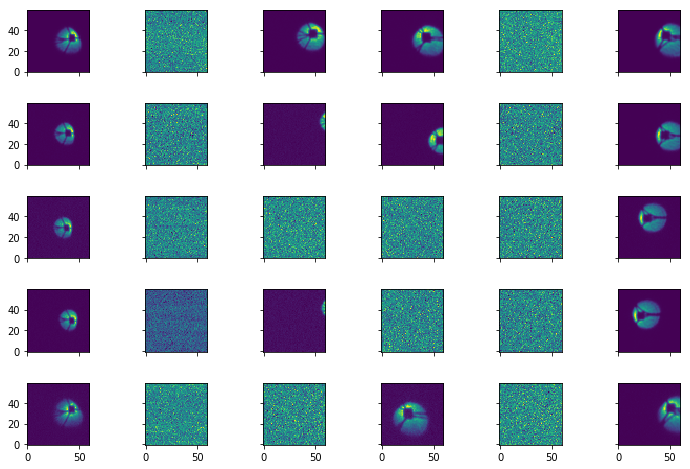

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24171_20210129T16h54.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24172 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024172/calExp-LA024172r2.fits
#Fiber= 6 and #peak= 5


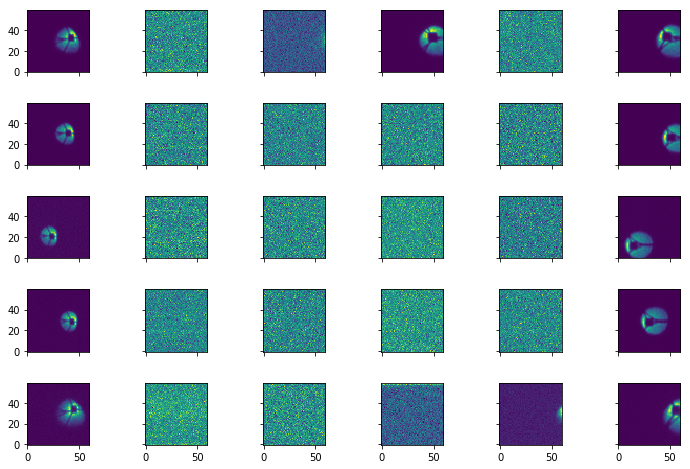

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24172_20210129T16h55.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24173 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024173/calExp-LA024173r2.fits
#Fiber= 6 and #peak= 5


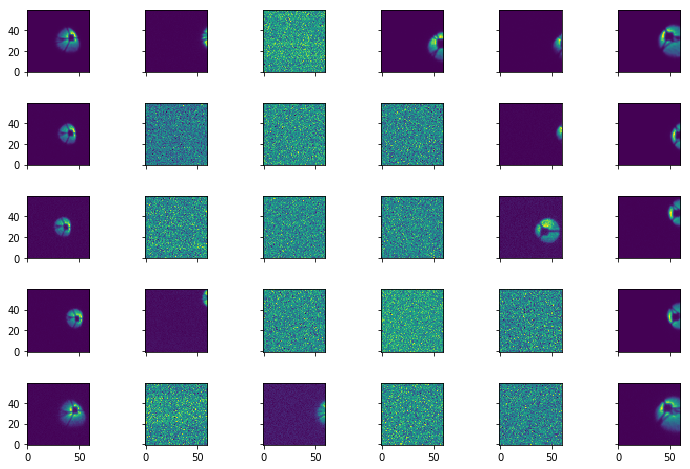

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24173_20210129T16h55.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24174 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024174/calExp-LA024174r2.fits
#Fiber= 6 and #peak= 5


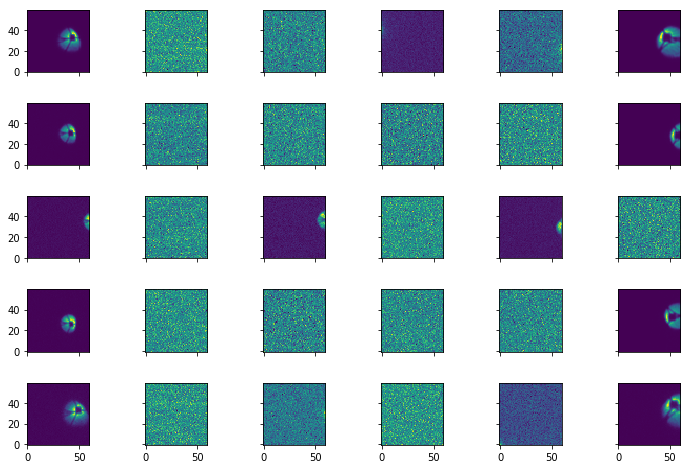

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24174_20210129T16h55.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24175 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024175/calExp-LA024175r2.fits
#Fiber= 6 and #peak= 5


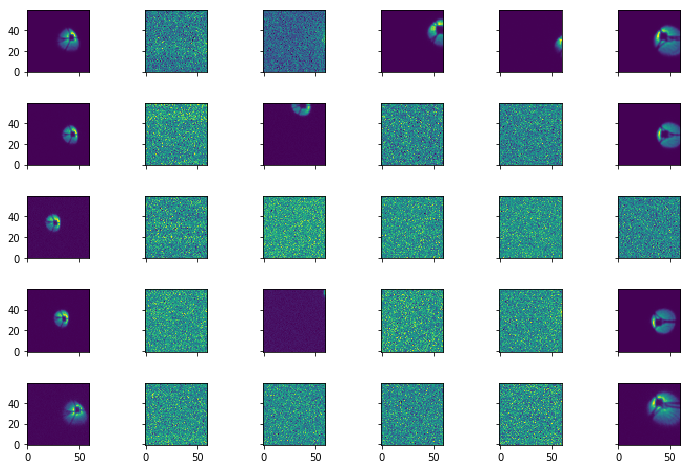

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24175_20210129T16h56.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24176 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024176/calExp-LA024176r2.fits
#Fiber= 6 and #peak= 5


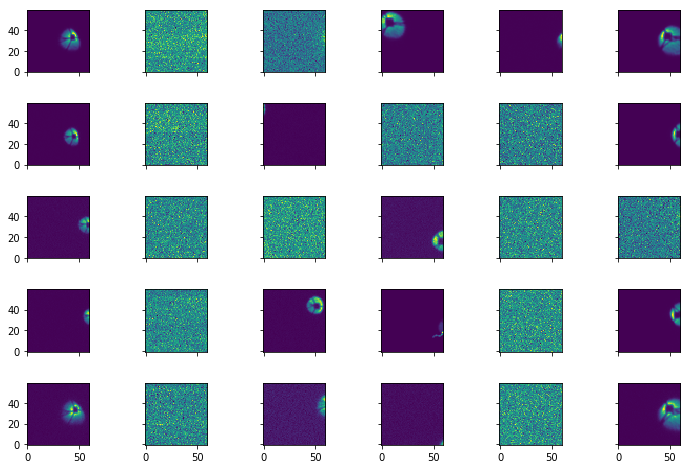

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24176_20210129T16h56.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24177 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024177/calExp-LA024177r2.fits
#Fiber= 6 and #peak= 5


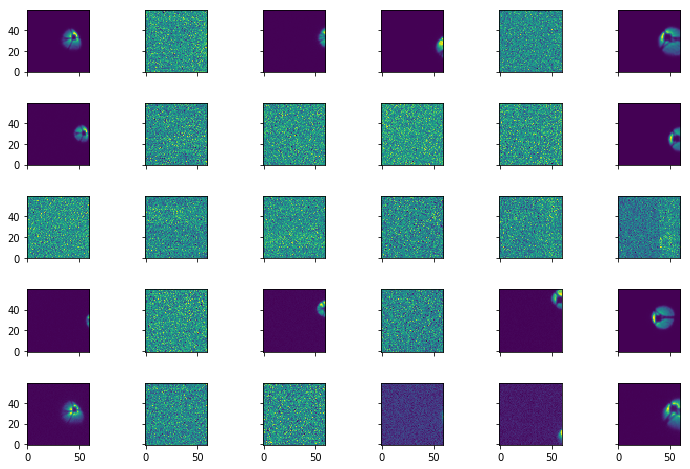

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24177_20210129T16h57.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24178 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024178/calExp-LA024178r2.fits
#Fiber= 6 and #peak= 5


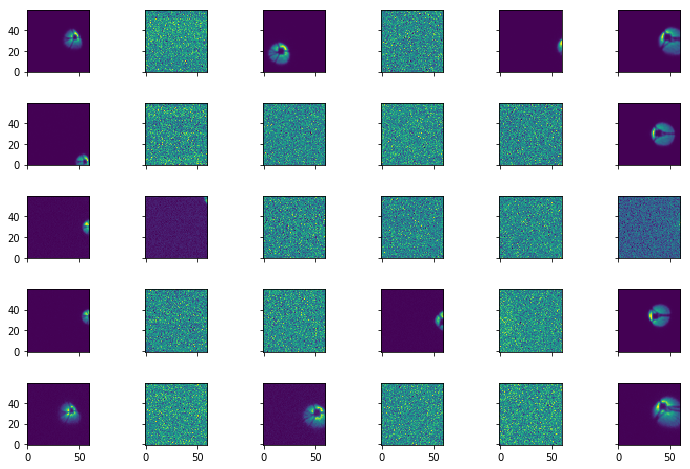

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24178_20210129T16h57.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24179 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024179/calExp-LA024179r2.fits
#Fiber= 6 and #peak= 5


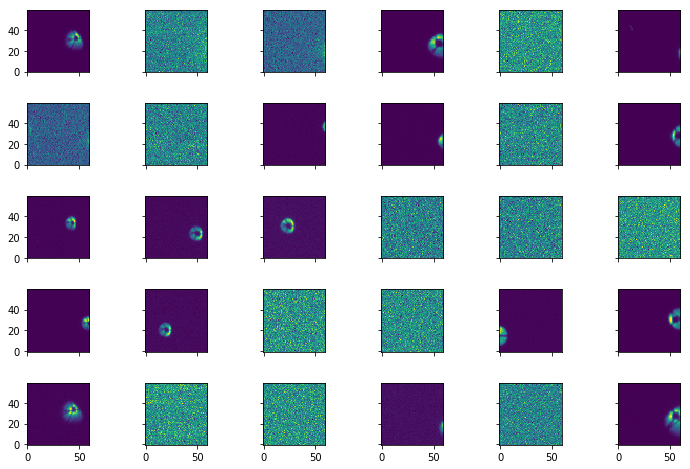

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24179_20210129T16h58.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24180 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024180/calExp-LA024180r2.fits
#Fiber= 6 and #peak= 5


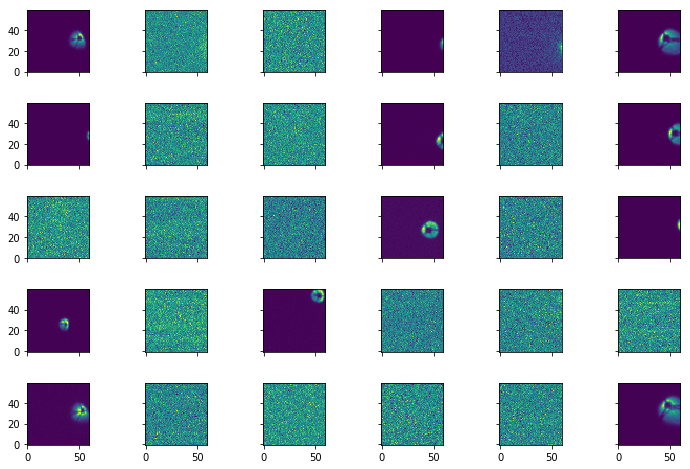

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24180_20210129T16h58.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24181 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024181/calExp-LA024181r2.fits
#Fiber= 6 and #peak= 5


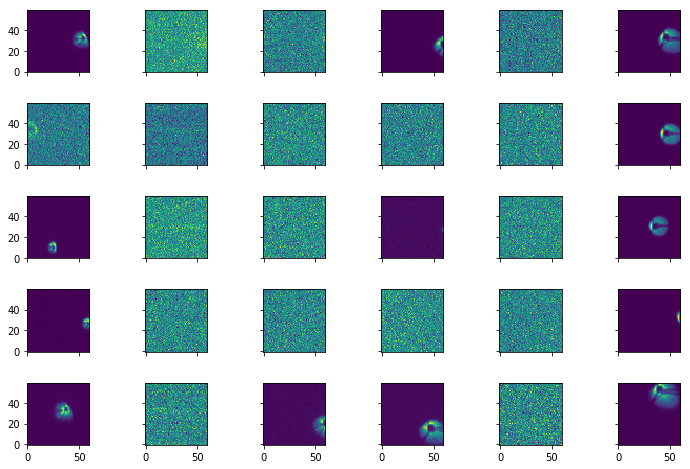

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24181_20210129T16h59.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24182 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024182/calExp-LA024182r2.fits
#Fiber= 6 and #peak= 5


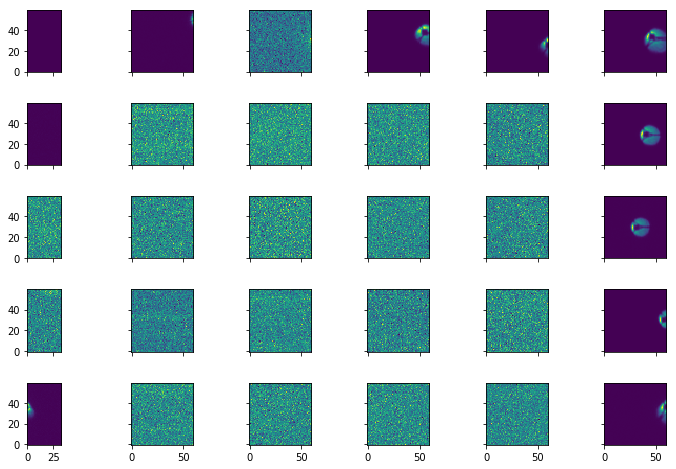

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24182_20210129T16h59.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24183 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024183/calExp-LA024183r2.fits
#Fiber= 6 and #peak= 5


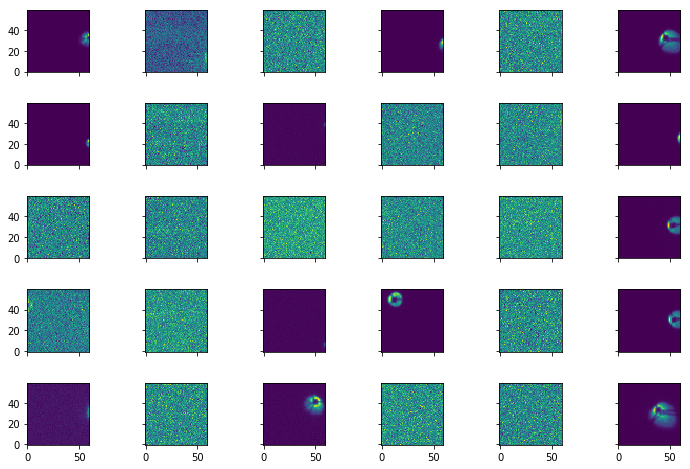

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24183_20210129T17h00.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24184 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024184/calExp-LA024184r2.fits


/home/pfs/dev/lib/pfs/imageAnalysis.py:147: RuntimeWarning: invalid value encountered in float_scalars
  return np.sum(ee)/np.sum(roi), np.sum(roi)


#Fiber= 6 and #peak= 5


/software/drp/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/image.py:855: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)


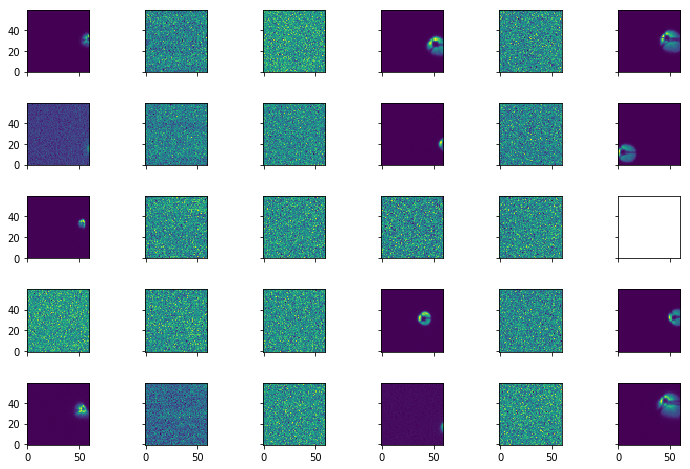

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24184_20210129T17h00.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24185 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024185/calExp-LA024185r2.fits
#Fiber= 6 and #peak= 5


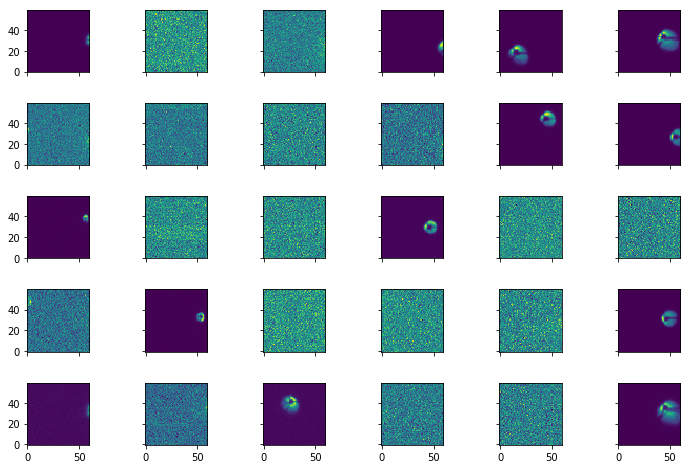

/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/Imquality_r2_Exp173_24185_20210129T17h00.csv
/drp/analysis/sm2/Exp173/ws_slit_roi60/doBckTrue/
Start visit 24186 of r2 with Imqual_LAM_peaklist_DEBUG_R3_Jan2020_WS_slit_2.csv
/drp/sps/rerun/ws_slit/detrend/
lamps used: ['HgAr']
['Ar']
/drp/sps/rerun/ws_slit/detrend/calExp/2021-01-19/v024186/calExp-LA024186r2.fits
not enough values to unpack (expected 1, got 0) cx:1070, cy:4024
#Fiber= 6 and #peak= 5


ValueError: cannot convert float NaN to integer

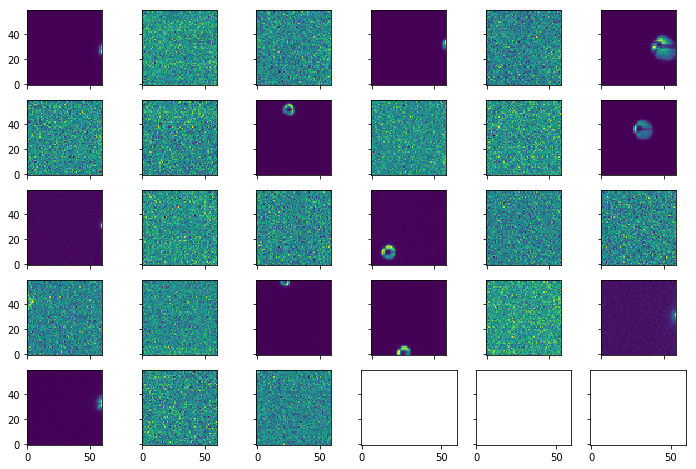

In [27]:
    # define defaut parameters
    roi_size = 60
    com = True  # Center Of Mass
    doBck = True
    head = 0
    tail = 0
    criteria = 'EE5'
    verbose = True
    doPrint = False
    arm = cam[0]
    
    drpPath = "/drp"
    repo = "sps"
    basePath = '/drp/analysis/sm2/'
    extra = ''
    
    for visit in range(visitStart, visitEnd+1):

            
        csvPath = basePath+"Exp"+str(experimentId)+"/"+rerun+"_roi"+str(roi_size)+"/doBck"+str(doBck)+"/"+extra
        print(csvPath)

    #    peakPath ="/home/fmadec/dev/ait-notebook/optical/input/"
    #    peaklist = peakPath+peaklist
    #    peaklist = "/drp/cluster/devel/ait-notebook/fmadec/Subaru/SM1/selectLines/Imqual_LAM_peaklist_2020July.csv"
#        peaklist = "SM2_peak_engineering_20201210.csv"        
#        peaklist = "SM2_peak_dcb2_20201211.csv"
#        peaklist = "Imqual_LAM_peaklist_DEBUG_B2_9peaks_Dec2020.csv"

#        peaklist = "SM2_peak_dcb2_neon_20201211.csv"


    #   VisitImageQualityToCsv(visit, peaklist, roi_size, cam=cam, \
    #                          repo="sm1",rerun="ginga",  cluster=True, \
    #                          com=True, doBck=True, EE=[3,5], doFit=True, doLSF=False,
    #                          csv_path = outpath)

        print(f'Start visit {visit} of {cam} with {peaklist}')
        print(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")

        butler = dafPersist.Butler(f"{drpPath}/{repo}/rerun/{rerun}/detrend/")
        rbutler = dafPersist.Butler(f"{drpPath}/{repo}/")
        rbutler.getKeys('raw')
        lamps = rbutler.queryMetadata('raw', ['lamps'], visit=visit, arm=arm) 
        print(f"lamps used: {lamps}")
        calExp = butler.get("calexp", visit=visit, arm=cam[0])

        peaks = pd.read_csv(peaklist)
 #       selected_peaks = peaks[peaks.arm == arm]
 #       selected_peaks = selected_peaks[(selected_peaks.element.str.contains('|'.join(re.findall('[A-Z][^A-Z]*', "".join(lamps)))))]
        selected_peaks = peaks
        print(peaks.element.unique())
        visit = int(visit)
        calExp = butler.get("calexp", visit=visit, arm=cam[0])
        calexfilePath = butler.getUri("calexp", visit=visit, arm=cam[0])
        if verbose:
            print(calexfilePath)

        VisitImageQualityToCsv(visit, selected_peaks, roi_size,\
                               drpImage=[ calExp.image.array, calexfilePath, visit],\
                               com=com, doBck=doBck, EE=[5,20], doFit=True, doLSF=False,\
                               cam=cam, repo=None,rerun=None, cluster=False, doPlot=True,\
                               doSep=False, mask_size=20, threshold= 50, subpix = 5 , maxPeakDist=80,\
                               maxPeakFlux=40000, minPeakFlux=2000,\
                               csv_path = csvPath, experimentId=experimentId, doPrint=verbose)